In [ ]:
from google.colab import drive
drive.mount('/content/drive')

![banner.jpeg](attachment:56a16b8b-2cc9-46e9-9b44-465ac20bfd83.jpeg)

# Procesamiento de Lenguaje Natural (NLP): Análisis (clasificación) de sentimientos

In [35]:
%pip install git+https://github.com/erikavaris/tokenizer.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/erikavaris/tokenizer.git to /tmp/pip-req-build-85ivhkww
  Running command git clone -q https://github.com/erikavaris/tokenizer.git /tmp/pip-req-build-85ivhkww


In [36]:
import string

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

from tokenizer import tokenizer as tk


In [37]:
pd.set_option('display.max_colwidth', None)

In [38]:
# Descargando las stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
# Función para tokenizar los comments
def tokenizer(text):
    rt = tk.RedditTokenizer()
    return rt.tokenize(text)

### Loading comments

In [40]:
comments_df = pd.read_csv('SuicidiosProyecto_clean.csv', sep = ',', names = ['id','text','class'], index_col='id',header = 1)




In [41]:
comments_df.shape

(135696, 2)

In [42]:
comments_df.sample(5)

,text,class
id,,
174541,hopeless about the future sometimes i really hate being gen z there is so much weve inherited that the adults in the world seem to have dumped on us to fix take climate change there is so much we have to do and give up just to not destroy our goddamn planet boomers dont even worry because theyll be dead by then but at least you have the legal power to fucking change anything i cant fucking vote on anything and all the things ill have to change they say you have to go vegan because its the best diet to be eco friendly but of the foods i like contain animal products and everything vegan is usually so expensive food is one of the things that makes me happy and giving up good food just makes me imagine a future where im sitting at a table with a salad topped with pine nuts day after day after day im so scared for the future all it seems to be is apocalypse and death i cant imagine a world where i will never see my parents and my dogs again i can just imagine crying over their graves begging for them to come back every day there seems to be a new group being genocided and tortured in a far off country and i cant do anything but spread awareness but most of the people who follow me on social media are people without much income minors every day since im american my president is ruining our relationships with other countries and turning over environmental policies and making us a laughingstock excuse me mr president i want people to want to help me when everything inevitably goes to shit instead of shun me for my countrys decisions against them im sick of it im sick of people dying im sick of people not wearing a mask im sick of wars going on for such stupid things im sick of racial and religion and gender genocide im sick of being scared because i have a uterus i dont want to be raped im sick of being scared that my marriage rights could be taken away just because i like other girls even though my family is solidly middle class and doing well because my dad is essential hes a radio host the decision of some celebrity to do something sexual on tv or say something dumb about a company could plunge us down where we were when i was little when both my parents were unemployed and there was a recession i dont want to be killed by some crazy person in my school with an ar if youre an adult reading this please make the right decisions please use your voice for those who cant,non-suicide
305611,why is school so hated here i m just wondering because i personally love school and don t see how you can dislike it school is good and challenging and makes me learn that means i can go into the future and do whatever i want i don t understand the hatred for it school opens opportunities for all who are enrolled and it is the best way to learn maybe school is different in the us i m in uk but surely it is not bad i d like to know reasons in the comments edit friends are another great benefit to school,non-suicide
287354,guys ive gotten some important information on america removed,non-suicide
153899,i deleted the reddit app and installed boost cause it s infinity better,non-suicide
337553,im tired im tired plz help in germany its in the morning maybe i shouldn t be on the phone,non-suicide


In [43]:
comments_df['class'].value_counts(dropna = False, normalize = True)

non-suicide    0.59057
suicide        0.40943
Name: class, dtype: float64

### Filtrando los comments que aún no han sido etiquetados

In [44]:
comments_labeled_df = comments_df.loc[comments_df['class'].notnull()]

In [45]:
# comments a ser usados para entrenar y evaluar el modelo
comments_labeled_df.shape

(135696, 2)

In [46]:
# comments descartados debido a que no se encuentran etiquetados
comments_df.loc[comments_df['class'].isnull()].shape

(0, 2)

In [47]:
# Scenario 1: Treating neutral as suicide classes
#comments_labeled_df['class'] = comments_labeled_df['class'].replace({'neutral': 'suicide'})

# Scenario 2: Working only with suicide and non-suicide classes
# Removing neutral class
comments_labeled_df = comments_labeled_df.loc[comments_labeled_df['class'].isin(['suicide', 'non-suicide'])]

# Scenario 3: Working with all classes

In [48]:

comments_labeled_df['class'].value_counts(dropna = False, normalize = True)

non-suicide    0.59057
suicide        0.40943
Name: class, dtype: float64

### Diviendo los comments etiquetados en los conjuntos de entrenamiento y prueba

In [49]:
# El parámetro 'stratify' es útil para asegurar que ambos conjuntos de datos queden aproximadamente balanceados
# Cuando se cuenta con muy pocos datos etiquetados, por lo general se debe disponer de una menor cantidad de datos para evaluación
X_train, X_test, y_train, y_test = train_test_split(comments_labeled_df['text'], comments_labeled_df['class'], test_size = 0.35, stratify = comments_labeled_df['class'], random_state = 1)

In [50]:
X_train.shape

(88202,)

In [51]:
pd.Series(y_train).value_counts(normalize = True)

non-suicide    0.590565
suicide        0.409435
Name: class, dtype: float64

In [52]:
X_test.shape

(47494,)

In [53]:
pd.Series(y_test).value_counts(normalize = True)

non-suicide    0.59058
suicide        0.40942
Name: class, dtype: float64

### Vectorizando los comments

<table>
    <tbody>
        <tr>
            <td>
                <h4>Bag of Words</h4>
                <img src="./imgs/bow.png" style="width: 500px;">
            </td>
            <td>
                <h4>TF-IDF</h4>
                <img src="./imgs/tf-idf.png" style="width: 500px;">
            </td>
        </tr>
    </tbody>
</table>

In [54]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True)

In [55]:
X_train.head()

id
299183                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [56]:
X_bow = bow.fit_transform(X_train.values.astype('U'))

In [57]:
len(bow.vocabulary_)

85235

In [58]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True)

In [59]:
X_tfidf = tfidf.fit_transform(X_train.values.astype('U'))

In [60]:
len(tfidf.vocabulary_)

85235

### Entrenando y evaluando un modelo usado BoW

In [ ]:
bow_model = RandomForestClassifier(random_state = 2)

In [ ]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<AxesSubplot:>

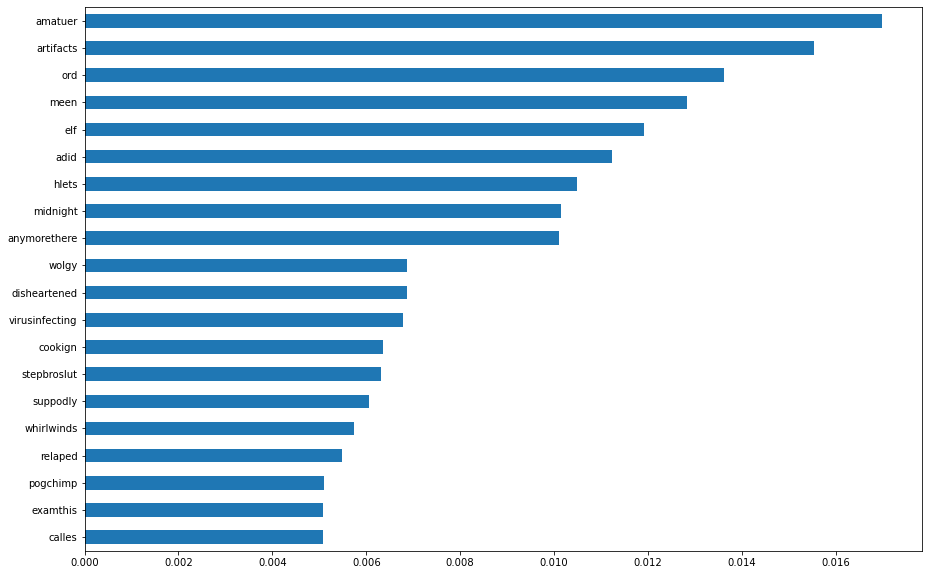

In [ ]:
# La 'feature importance' en modelos basados en árboles de decisión indican cuales son las características más importantes al momento de tomar una decisión
pd.Series(bow_model.feature_importances_, index = bow.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

In [ ]:
bow_estimators = bow_model.estimators_
print('Number of trees:', len(bow_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 1684.07


In [ ]:
y_train_bow_predict = bow_model.predict(X_bow)

In [ ]:
y_test_bow_predict = bow_model.predict(bow.transform(X_test.values.astype('U')))

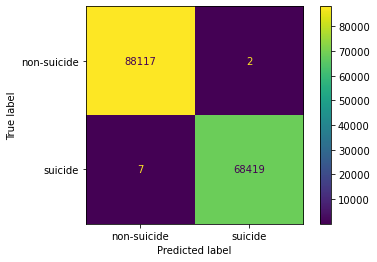

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

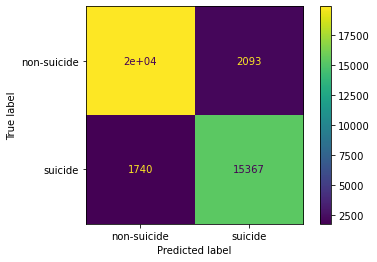

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [ ]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_bow_predict, pos_label = 'suicide'))
    print('Recall:', recall_score(y_train, y_train_bow_predict, pos_label = 'suicide'))
    print('F1:', f1_score(y_train, y_train_bow_predict, pos_label = 'suicide'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_bow_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_bow_predict, average = None))
    print('F1:', f1_score(y_train, y_train_bow_predict, average = None))

Precision: 0.999970769208284
Recall: 0.9998976997047906
F1: 0.9999342331216614


In [ ]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_bow_predict, pos_label = 'suicide'))
    print('Recall:', recall_score(y_test, y_test_bow_predict, pos_label = 'suicide'))
    print('F1:', f1_score(y_test, y_test_bow_predict, pos_label = 'suicide'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
    print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: 0.8801260022909507
Recall: 0.8982872508329923
F1: 0.8891138947551133


### Entrenando y evaluando un modelo usado TF-IDF

In [ ]:
tfidf_model = RandomForestClassifier(random_state = 3)

In [ ]:
tfidf_model.fit(X_tfidf, y_train)

KeyboardInterrupt: ignored

In [ ]:
pd.Series(tfidf_model.feature_importances_, index = tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

In [ ]:
tfidf_estimators = tfidf_model.estimators_
print('Number of trees:', len(tfidf_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in tfidf_estimators]))

In [ ]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test.values.astype('U')))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [ ]:
if len(bow_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_tfidf_predict, pos_label = 'suicide'))
    print('Recall:', recall_score(y_train, y_train_tfidf_predict, pos_label = 'suicide'))
    print('F1:', f1_score(y_train, y_train_tfidf_predict, pos_label = 'suicide'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_tfidf_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_tfidf_predict, average = None))
    print('F1:', f1_score(y_train, y_train_tfidf_predict, average = None))

In [ ]:
if len(tfidf_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_tfidf_predict, pos_label = 'suicide'))
    print('Recall:', recall_score(y_test, y_test_tfidf_predict, pos_label = 'suicide'))
    print('F1:', f1_score(y_test, y_test_tfidf_predict, pos_label = 'suicide'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
    print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

### Entrenamiento de un modelo SVM


In [61]:
from sklearn.linear_model import LogisticRegression

In [62]:
lr_model = LogisticRegression(class_weight = "balanced")

In [63]:
lr_model.fit(X_tfidf, y_train)

LogisticRegression(class_weight='balanced')

In [64]:
y_train_svm_predict = lr_model.predict(X_tfidf)

In [72]:
X_test_tfidf = tfidf.transform(X_test.values.astype('U'))

In [ ]:
type(X_tfidf)

scipy.sparse.csr.csr_matrix

In [75]:
y_test_svm_predict = lr_model.predict(X_test_tfidf)

ValueError: ignored

In [ ]:
X_bow_lr = bow.fit_transform(X_train.values.astype('U'))

In [ ]:
lr_model = LogisticRegression(class_weight = "balanced")

In [ ]:
lr_model.fit(X_bow_lr, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(class_weight='balanced')

In [ ]:
y_train_lr_predict = lr_model.predict(X_bow_lr)

In [ ]:
X_test_lr = bow.fit_transform(X_test.values.astype('U'))

In [ ]:
y_test_lr_predict = lr_model.predict(X_test_lr)

ValueError: ignored

### Análisis del error

In [ ]:
error_df = pd.concat(
    [ pd.concat([X_test, y_test], axis = 1).reset_index(),
    pd.Series(y_test_tfidf_predict) ]
, axis = 1).rename(columns = { 'class': 'actual', 0: 'predicted' })

error_df.drop('id', inplace = True, axis = 1)

NameError: ignored

In [ ]:
error_df.loc[error_df['actual'] != error_df['predicted']].shape

In [ ]:
error_df.loc[error_df['actual'] != error_df['predicted']].sample(10)

### Model selection

In [ ]:
pipeline = Pipeline(steps = [
    ('vectorizer', CountVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True)),
    ('classifier', RandomForestClassifier(random_state = 4))
])

In [ ]:
param_grid = {
    'vectorizer': [CountVectorizer(tokenizer = tokenizer, stop_words = stop_words), TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words)],
    'vectorizer__lowercase': [True, False],
    'classifier__n_estimators': [50, 100, 150, 200, 250, 300],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [20, 40, 60, 80]
}

In [ ]:
search = GridSearchCV(pipeline, param_grid, scoring = ['precision', 'recall', 'f1'], refit = 'f1', cv = 10, return_train_score = True, verbose = 1)

In [ ]:
search.fit(X_train.values.astype('U'), y_train.replace({'non-suicide': 0, 'suicide': 1}))

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


KeyboardInterrupt: 

In [ ]:
search.best_params_

In [ ]:
search.best_score_

In [ ]:
y_test_search_predict = search.best_estimator_.predict(X_test)

In [ ]:
print('Precision:', precision_score(y_test.replace({'non-suicide': 0, 'suicide': 1}), y_test_search_predict))
print('Recall:', recall_score(y_test.replace({'non-suicide': 0, 'suicide': 1}), y_test_search_predict))
print('F1:', f1_score(y_test.replace({'non-suicide': 0, 'suicide': 1}), y_test_search_predict))